# Метод разностей в разностях (DiD)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

In [6]:
from pyfixest.utils.dgps import get_sharkfin

df_one_cohort = get_sharkfin()
df_one_cohort.head()

,unit,year,treat,Y,ever_treated
0,0,0,0,1.629307,0
1,0,1,0,0.825902,0
2,0,2,0,0.208988,0
3,0,3,0,-0.244739,0
4,0,4,0,0.804665,0


### Структура данных: панель и блоковое вмешательство

Рассматриваем данные в **панельном формате**, где много наблюдаемых объектов (пользователей, регионов и т.д.), и для каждого объекта есть несколько временных периодов.

#### Структура матрицы метрик

Массив значений метрик (например, выручки, конверсии и т.д.) обозначается как:

$$
\mathbf{Y}^{\text{thin}} =
\begin{pmatrix}
Y_{11} & Y_{12} & Y_{13} \\
Y_{21} & Y_{22} & Y_{23} \\
Y_{31} & Y_{32} & Y_{33} \\
Y_{41} & Y_{42} & Y_{43} \\
Y_{51} & Y_{52} & Y_{53} \\
Y_{61} & Y_{62} & Y_{63} \\
\vdots & \vdots & \vdots \\
Y_{N1} & Y_{N2} & Y_{N3}
\end{pmatrix}
$$

Здесь:
- Каждая строка — это отдельный объект (например, пользователь, магазин, город и т.д.)
- Каждый столбец — это определённый временной период (например, месяц, неделя)

Такой формат называют **"тонкой" панелью** (**thin panel**) — когда объектов много (большой `N`), но временных периодов (столбцов) — мало (`T` маленькое).

#### Структура вмешательства: block assignment

Массив вмешательств обозначается как:

$$
\mathbf{W}^{\text{block}} =
\begin{pmatrix}
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 1 & \ldots & 1 & 1
\end{pmatrix}
$$

Здесь:
- `0` — означает, что в этот момент объект ещё не подвергался вмешательству.
- `1` — означает, что с этого момента объект считается «обработанным» (например, получил доступ к новой функции, участвовал в акции и т.д.)

Такой тип структуры называется **block assignment** — объекты получают вмешательство не одновременно, но после некоторого общего времени запуска (например, начиная с 4-го периода).

#### Визуализация с помощью `panelview`

Для наглядности можно использовать инструмент `panelview` (например, в R или Python), который позволяет:

- посмотреть, **сколько объектов** находятся в группе контроля и теста в каждый период;
- визуально убедиться, когда начинается вмешательство и для каких единиц;
- проверить наличие перекрытий, пропусков, структуру rollout-а и пр.

And plot the evolution of the outcome variable for treated and control единиц

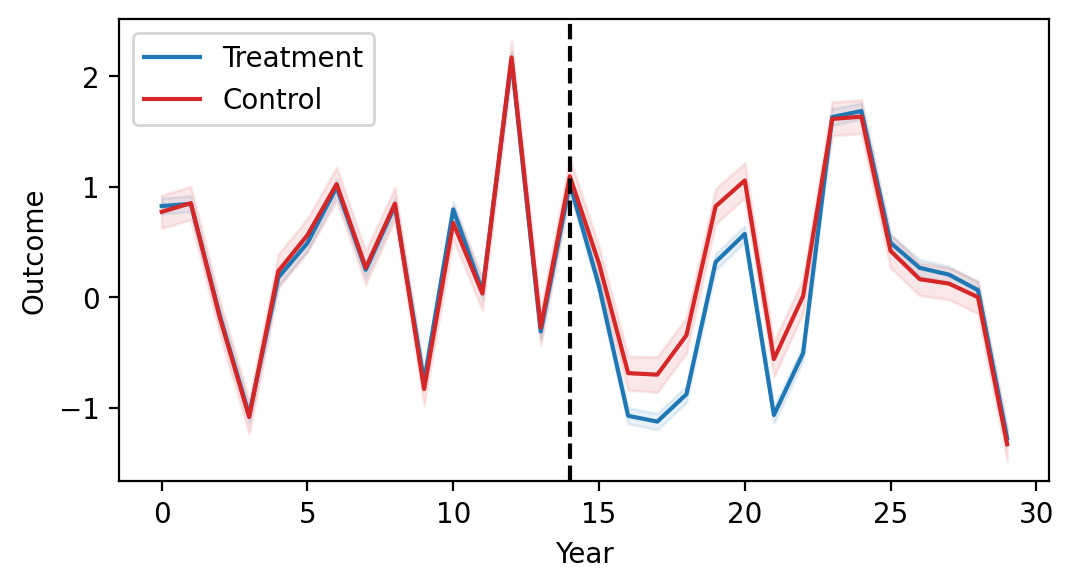

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = df_one_cohort.groupby(["year", "ever_treated"])["Y"].mean().unstack()
std_errors = df_one_cohort.groupby(["year", "ever_treated"])["Y"].sem().unstack()

# Plot means
means.plot(ax=ax, color=['tab:blue', 'tab:red'])

# Add standard errors
ax.fill_between(means.index, means.iloc[:, 0] - std_errors.iloc[:, 0], means.iloc[:, 0] + std_errors.iloc[:, 0], color='tab:blue', alpha=0.1)
ax.fill_between(means.index, means.iloc[:, 1] - std_errors.iloc[:, 1], means.iloc[:, 1] + std_errors.iloc[:, 1], color='tab:red', alpha=0.1)

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left", labels=["Treatment", "Control"])
plt.axvline(x=14, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

### Двухфакторная модель с фиксированными эффектами (TWFE)

Метод двухфакторных фиксированных эффектов (Two-Way Fixed Effects, TWFE) — это расширение метода разностей в разностях (DID), которое учитывает:
- **постоянные различия между объектами** (фиксированные эффекты по объектам, `αᵢ`),
- **влияние времени** (фиксированные эффекты по времени, `βₜ`),
- и, при этом, позволяет оценить **средний эффект вмешательства (`τ`)**.

#### Основные предположения

1. Поведение объектов до вмешательства не должно зависеть от того, что это вмешательство произойдёт в будущем.

2. **Параллельные тренды**  
   Без вмешательства средние значения целевой метрики у контрольной и тестовой групп развивались бы одинаково.


#### Модель без вмешательства:

$$
Y_{it}(0) = \alpha_i + \beta_t + \varepsilon_{it}
$$

- `Y_{it}(0)` — значение метрики без вмешательства  
- `αᵢ` — фиксированный эффект для объекта  
- `βₜ` — фиксированный эффект времени  
- `εᵢₜ` — случайная ошибка


#### Модель с постоянным эффектом вмешательства:

$$
Y_{it}(1) = Y_{it}(0) + \tau
$$

То есть, при наличии вмешательства, наблюдаемое значение увеличивается (или уменьшается) на константу `τ`.


#### Полная модель наблюдаемых данных:

$$
Y_{it} = \alpha_i + \beta_t + \tau W_{it} + \varepsilon_{it}
$$

- `W_{it}` — индикатор: применено ли вмешательство к объекту `i` в момент `t`.

#### Как оценивается эффект `τ`

Параметры модели (включая `τ`) можно найти методом наименьших квадратов:

$$
(\hat{τ}, \hat{α}, \hat{β}) = \arg\min \sum_{i,t} (Y_{it} - α_i - β_t - τ W_{it})^2
$$

#### Связь с классическим DID

Если в эксперименте только два периода (до и после) и две группы (тест и контроль), оценка `τ` сводится к обычной формуле разностей в разностях:

$$
\hat{τ} = ( \bar{Y}_{\text{тест, после}} - \bar{Y}_{\text{тест, до}} ) - ( \bar{Y}_{\text{контроль, после}} - \bar{Y}_{\text{контроль, до}} )
$$

#### Что, если эффект не одинаков для всех?

Даже если эффект вмешательства (`τ`) отличается у разных объектов и в разные моменты времени, метод всё равно может дать полезную оценку — **средний эффект для обработанных объектов (ATT)**.

При более сложных сценариях (например, динамические эффекты во времени), интерпретация `τ` становится менее очевидной, но всё ещё возможно оценить среднее влияние вмешательства.

In [10]:
fit_static_twfe = pf.feols("Y ~ treat | unit + year",
                           df_one_cohort, vcov={"CRV1": "unit"})
fit_static_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treat         |      0.206 |        0.052 |     3.927 |      0.000 |  0.103 |   0.308 |
---
RMSE: 0.701 R2: 0.905 R2 Within: 0.003 


### Анализ динамики эффекта: Event Study

Когда в продукте запускается изменение (например, новая функция, рекламная кампания или скидка), важно понять не только, был ли эффект, но и как он развивался во времени:

- появился ли эффект сразу или с задержкой;
- усиливался ли он со временем;
- не начались ли изменения ещё до официального запуска.

Для этого используют модель event study, которая позволяет оценить эффект вмешательства отдельно для каждого периода до и после события.

#### Математическая модель

$$
Y_{it} = \alpha_i + \beta_t + \sum_{k \ne 0} \tau_k \cdot W_{it}^{(k)} + \varepsilon_{it}
$$

где:
- \( Y_{it} \) — значение метрики для объекта \( i \) в момент времени \( t \);
- \( \alpha_i \) — фиксированный эффект объекта (например, склонность пользователя к покупкам);
- \( \beta_t \) — фиксированный эффект времени (например, сезонные колебания или тренды);
- \( W_{it}^{(k)} \) — индикатор того, находится ли объект \( i \) в периоде \( k \) относительно момента вмешательства:
  - \( k = -1 \) — один период до;
  - \( k = 1 \) — один период после;
  - \( k = 0 \) — момент вмешательства (не включается в модель и используется как базовый уровень);
- \( \tau_k \) — эффект вмешательства в периоде \( k \).

#### Назначение модели

Модель позволяет:
- определить, с какого момента начал проявляться эффект;
- оценить, как эффект изменяется во времени (растёт, исчезает или стабилен);
- проверить корректность предпосылок (например, гипотезу о параллельных трендах до вмешательства).

#### Интерпретация результатов

- Эффекты до вмешательства (например, \( \tau_{-3}, \tau_{-2}, \tau_{-1} \)) должны быть близки к нулю — это свидетельствует о соблюдении параллельных трендов.
- Эффекты после вмешательства (например, \( \tau_1, \tau_2, \tau_3 \)) отражают силу и длительность эффекта.
- Если эффекты появляются ещё до момента вмешательства (до \( k = 0 \)), это может указывать на предвосхищение пользователями или нарушение экспериментальных условий.

In [14]:
fit_dynamic_twfe = pf.feols("Y ~ i(year, ever_treated, ref = 14) | unit + year",
                            df_one_cohort, vcov={"CRV1": "unit"})
fit_dynamic_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient                                        |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(year, contr.treatment(base=14))[0]:ever_treated  |     -0.118 |        0.075 |    -1.577 |      0.115 | -0.265 |   0.029 |
| C(year, contr.treatment(base=14))[1]:ever_treated  |     -0.059 |        0.080 |    -0.736 |      0.462 | -0.215 |   0.098 |
| C(year, contr.treatment(base=14))[2]:ever_treated  |     -0.080 |        0.081 |    -0.982 |      0.326 | -0.240 |   0.080 |
| C(year, contr.treatment(base=14))[3]:ever_treated  |     -0.084 |        0.083 |    -1.014 |      0.311 | -0.246 |   0.078 |
| C(year, contr.treatment(base=14))[4]:ever_treated  |     -0.009 |        0.081 |    -0.108 |      0.914 | -0.167 |   0.150 |
| C(year, c

What happens if you don't use simultaneous (joint) confidence intervals?

In [15]:
from pyfixest.report.utils import rename_event_study_coefs

In [17]:
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[200, 50],
    yintercept=0,
    xintercept=13.5,
    joint="both",
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

### Поэтапное внедрение (Staggered Adoption)

В реальных сценариях вмешательство (например, новая функция или программа лояльности) часто **внедряется поэтапно** — не для всех пользователей одновременно, а в разные моменты времени.

Такая структура называется **staggered adoption** — поэтапное принятие.

#### Структура вмешательства

Массив вмешательств может выглядеть так:

$$
\mathbf{W}^{\text{stag}} =
\begin{pmatrix}
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 1 \\
0 & 0 & 0 & 0 & \ldots & 1 & 1 \\
0 & 0 & 0 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 1 & 1 & 1 & \ldots & 1 & 1 \\
\end{pmatrix}
$$

Каждая строка — это отдельный пользователь (или объект), каждый столбец — момент времени.

- `0` означает, что пользователь ещё не получил доступ к нововведению;
- `1` означает, что пользователь уже под действием вмешательства.

Слева направо в строках видно:
- **Никогда не получившие вмешательство** (never adopter)
- **Очень поздние пользователи** (very late adopter)
- **Поздние** (late adopter)
- **Средние** (medium adopter)
- и т.д.

#### Момент начала вмешательства

Для каждого пользователя определим момент активации вмешательства:

$$
A_i \equiv T+1 - \sum_{t=1}^{T} W_{it}
$$

Здесь:
- \( A_i \) — это период, когда пользователь впервые получил вмешательство;
- если пользователь **никогда** не получил вмешательство, то \( A_i = \infty \) по соглашению;
- \( N_a \) — количество пользователей с датой активации \( A_i = a \).

#### Оценка эффектов по времени и дате вмешательства

Теперь можно определить средний эффект вмешательства в момент времени \( t \), если пользователь начал пользоваться с периода \( a \):

$$
\tau_{t \mid a} \equiv \mathbb{E}\left[Y_{it}(1) - Y_{it}(0) \mid A_i = a \right]
$$

То есть:
- эффект может **зависеть не только от времени**, но и от того, **когда пользователь начал участвовать**;
- важно отдельно отслеживать траектории эффекта для групп с разной датой активации.

#### Зачем это нужно

- В поэтапных запусках эффект может проявляться по-разному в зависимости от даты внедрения;
- Некоторые пользователи могли быть более или менее готовы к изменению;
- Для корректной оценки эффекта важно **разделять влияние времени и даты вступления во вмешательство**.

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# параметры
n_units = 100  # количество объектов
n_periods = 10  # количество периодов
unit_ids = np.arange(1, n_units + 1)
time_periods = np.arange(1, n_periods + 1)

# датафрейм всех комбинаций (панель)
df = pd.DataFrame([(i, t) for i in unit_ids for t in time_periods], columns=["id", "t"])

# присвоим случайный период начала вмешательства или None (для контроля)
adoption_periods = np.random.choice(np.append(np.arange(4, 10), [np.inf]), size=n_units)
df["g"] = df["id"].map(dict(zip(unit_ids, adoption_periods)))

# бинарный индикатор вмешательства: D = 1, если t >= g
df["D"] = (df["t"] >= df["g"]).astype(int)

# фиксированные эффекты по объекту и по времени
unit_fe = dict(zip(unit_ids, np.random.normal(0, 1, n_units)))
time_fe = dict(zip(time_periods, np.random.normal(0, 1, n_periods)))

# гетерогенные эффекты по времени после вмешательства
def treatment_effect(t, g):
    if np.isinf(g) or t < g:
        return 0
    else:
        return 1 + 0.2 * (t - g)  # эффект растёт после внедрения

# итоговая метрика
df["y"] = df.apply(lambda row:
                   unit_fe[row["id"]] +
                   time_fe[row["t"]] +
                   treatment_effect(row["t"], row["g"]) +
                   np.random.normal(0, 1),
                   axis=1)

df = df.sort_values(["id", "t"]).reset_index(drop=True)

### Event Study с поэтапным вмешательством (разные группы)

Рассматриваем данные по периодам с **1990 по 2020 год**. Объекты разделены на три группы:

- **Группа 1** получила вмешательство в **2000 году**  
  - Групповой эффект вмешательства: **2**
  - Динамический эффект: увеличивается на **0.05 × k** после вмешательства

- **Группа 2** получила вмешательство в **2010 году**
  - Групповой эффект вмешательства: **1**
  - Динамический эффект: увеличивается на **0.15 × k** после вмешательства

- **Группа 3** — контроль, **вмешательство не применяется** (никогда не лечится)

#### Модель с динамикой эффекта:

Модель, отражающая временную динамику эффекта и его наличие **до и после вмешательства**:

$$
Y_{it} = \sum_{k = -K}^{-2} \tau^{\text{lead}}_k \cdot D_{it}^{(k)} +
         \sum_{k = 0}^{L} \tau^{\text{lag}}_k \cdot D_{it}^{(k)} +
         \alpha_i + \beta_t + \varepsilon_{it}
$$

Здесь:
- \( Y_{it} \) — метрика (например, прибыль, клики) для объекта `i` в момент времени `t`;
- \( D_{it}^{(k)} \) — индикатор того, что объект `i` находится в момент времени `t` на расстоянии `k` от момента вмешательства:
  - **lead (до вмешательства)**: \( k < 0 \)
  - **lag (после вмешательства)**: \( k \geq 0 \)
- \( \tau^{\text{lead}}_k \), \( \tau^{\text{lag}}_k \) — эффекты вмешательства до и после события;
- \( \alpha_i \) — фиксированный эффект для объекта;
- \( \beta_t \) — фиксированный эффект времени;
- \( \varepsilon_{it} \) — случайная ошибка.

#### Зачем это нужно:

- Можно отследить **предвосхищение вмешательства** (если \( \tau^{lead}_k \neq 0 \))
- Позволяет увидеть, как **эффект развивается со временем** — усиливается или угасает
- Учитывает **разные моменты старта вмешательства для разных групп**